<a href="https://colab.research.google.com/github/andreaco/andreaco.github.io/blob/main/CMRM_FeatureAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rhythmic Features Study

## Imports and Downloads

First of all, we need to install the *pretty-midi* library, download and unzip the Google Magenta 
Download and unzip MIDI dataset

In [11]:
! pip install pretty-midi

We need to download and unzip the [Expanded Groove MIDI Dataset (eGMD) ](https://magenta.tensorflow.org/datasets/e-gmd).  
This dataset is an expansion of the Groove MIDI Dataset (GMD). GMD is a dataset of human drum performances recorded in MIDI format on a Roland TD-11 electronic drum kit.

In [12]:
! wget https://storage.googleapis.com/magentadata/datasets/e-gmd/v1.0.0/e-gmd-v1.0.0-midi.zip
! unzip e-gmd-v1.0.0-midi.zip

--2020-12-27 23:31:21--  https://storage.googleapis.com/magentadata/datasets/e-gmd/v1.0.0/e-gmd-v1.0.0-midi.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 74.125.135.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107076192 (102M) [application/zip]
Saving to: ‘e-gmd-v1.0.0-midi.zip.1’

e-gmd-v1.0.0-midi.z 100%[===================>] 102.12M   301MB/s    in 0.3s    

2020-12-27 23:31:21 (301 MB/s) - ‘e-gmd-v1.0.0-midi.zip.1’ saved [107076192/107076192]

Archive:  e-gmd-v1.0.0-midi.zip
replace e-gmd-v1.0.0/LICENSE? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Here are the libraries that we used for doing this analysis 

In [13]:
import pandas as pd
import numpy as np
import pretty_midi
import librosa, librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
from pathlib import Path

from scipy import signal

## Preliminar Analysis

In the beginning we explored the dataset, by looking at its composition and labeling to understand better what could be useful to us and what not.

In [14]:
# Read CSV
info = pd.read_csv('e-gmd-v1.0.0/e-gmd-v1.0.0.csv')

# Print column names
print(list(info.columns))
print("N rows:", info.size)

['drummer', 'session', 'id', 'style', 'bpm', 'beat_type', 'time_signature', 'duration', 'split', 'midi_filename', 'audio_filename', 'kit_name']
N rows: 546444


After some trim we extract the file name, BPM and Genre labels

In [15]:
midi_files  = []
labels      = []
bpms        = []

for index, row in info.iterrows():
  # File name
  midi_files.append('e-gmd-v1.0.0/' + row['midi_filename'])
  # BPM
  bpms.append(row['bpm'])
  # Label (we keep only the main subgenre, the one before the '/')
  labels.append(row['style'].split('/')[0])

Here we analyze the balance between classes of the datasets by printing labels and number of occurences

In [16]:
lab, count = np.unique(np.asarray(labels), return_counts=True)
[(l, c) for l, c in zip(lab, count)]

[('afrobeat', 172),
 ('afrocuban', 2537),
 ('blues', 172),
 ('country', 1204),
 ('dance', 215),
 ('funk', 6364),
 ('gospel', 774),
 ('hiphop', 3827),
 ('jazz', 4171),
 ('latin', 3784),
 ('middleeastern', 43),
 ('neworleans', 2064),
 ('pop', 1118),
 ('punk', 2494),
 ('reggae', 860),
 ('rock', 13072),
 ('soul', 2666)]

## Feature definition

Here we defined some functions that use *pretty-midi* library to parse the MIDIs and quantize them to the representation that we used in our previous feature analysis 

In [17]:
def get_onsets(mid, midi_notes=[36]):
  """
  Given a pretty-midi object, and a list of midi notes 
  return the onsets for each midi notes in list

    Parameters
    ----------

    :param mid:
      pretty-midi object containing the drum beat

    :param midi_notes: optional, defaults to only kick
      list of midi notes to be considered in the onset extraction

    :return: List containing onsets time occurrence
  """
  # List that will contain our onsets
  onsets = []
  
  # For each instrument in our midi
  for instrument in mid.instruments:
    # For each note in our instrument note
    for note in instrument.notes:
      # If the note is in our midi notes list
      if(note.pitch in midi_notes):
        # Add the onsets to our onsets list
        onsets.append(note.start)
  # Return the onsets as a numpy array
  return np.asarray(onsets)
  
def onsets_parse(onsets, bpm, bars, n_quant_steps):
  """
  Given a list obtained from the get_onsets function, generate the relative
  representation with quantized arrays of 0s and 1s

    Parameters
    ----------

    :param onsets:
      onsets list generated from get_onsets function

    :param bpm:
      BPM of the original MIDI, used to quantize the onsets accordingly

    :param bars:
      Number of bars per pattern in our list

    :param n_quant_steps:
      Number of notes per bar (quantization factor)

    :return: A list of patterns for each bar found in the onsets list
  """
  # Quarter duration in seconds with the given BPM
  quarter_duration = 60/bpm

  # Duration of each pattern in seconds
  dur = bars*4*quarter_duration

  # Number of sequences (last onset time divided by duration of each pattern)
  n_sequences = int(np.ceil(np.max(onsets) / dur))

  # Total number of quantized steps needed to represent the entire MIDI
  tot_steps = n_quant_steps * n_sequences

  # List containing the quantized time (in seconds) for each of the steps, given the relative parameters
  # This is computed by dividing the total duration (in seconds) in the relative amount of steps
  quantized_time = np.linspace(0, dur*n_sequences, tot_steps)

  # We then create an array of 0s that will hold the quantized onsets (with 1s)
  patterns = np.zeros((tot_steps), dtype=int)

  # For each onset
  for k in onsets:
    # Get the quantized position by getting the index of the nearest quantized onset
    index = np.abs(k - quantized_time).argmin()
    # Then set its position in pattern to 1
    patterns[index] = 1

  # We then decided to reshape the pattern in different sequences each of n_quant_steps steps
  patterns = patterns.reshape(n_sequences, n_quant_steps)
  return patterns

By studying [this paper](https://www.sciencedirect.com/science/article/abs/pii/S0010027720300524), we decided to use 3 different kind of representations to compute our features:
> * **p**: A list of quantized beats, containing 1s in onset position and 0s otherwhise (i.e. [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0] represent a 4 on 4 beat with just 4 onsets)
* **x**: A list containing the onsets position in a relative time scale between 0 and 1. (i.e. [0.0, 0.25, 0.5, 0.75] is the representation of the rhythm stated before)
* **z**: Similar to the **x** representation but with the exception that the beats are wrapped around a unit circle.


In [18]:
def p2x(p):
  """
  Given a beat in p representation, returns the relative x representation
  """
  return np.nonzero(p)[0] / len(p)

def x2z(x):
  """
  Given a beat in x representation, returns the relative z representation
  """
  return np.exp(2*np.pi*1j*x)

By using the previously stated representation we are able to compute a different number of features.

In [19]:
def balance(z):
  """
  Balance description
  """
  N = len(z)
  if (N == 0): return 0
  else:             return 1 - np.abs(np.sum(z)) / N

def evenness(z):
  """
  Evenness description
  """
  N = len(z)
  k = np.arange(N)

  if (N == 0): return 0
  else:        return np.abs(np.sum(z*np.exp(-2*np.pi*1j*k / N)))/N

def distance(pattern): 
  """
  Returns the distance between consecutive onsets,
  accounting for the distance between the last and the first
  """
  n = len(pattern)  
  ons = np.nonzero(pattern)[0]

  if len(ons) > 0:
    last = n+ons[0]
  else:
    last = None
  return np.diff(ons, append=last)


def IOI(pattern):
  """
  Returns the PDF of distances between onsets
  """
  
  g = distance(pattern)
  
  unique, counts = np.unique(g, return_counts=True)

  N = np.sum(counts) # N is the number of intervals (== numbero of onsets)
  ans = [0]*(len(pattern) + 1) # Len of pattern + 1, taking into account seq with only one onset (distance 16 needs index 16)
  for i in range(len(unique)):
    ans[unique[i]] = counts[i] / N
  return ans
def entropy(ioi):
  N = len(ioi)
  ioi += np.finfo(float).eps
  return - np.sum(ioi*np.log(ioi)) / np.log(N)

## Subset of Dataset Creation

Since the dataset is unbalanced and after some tests, we decided to keep only a subset of it, by chosing the classes with most examples.
We reload the dataset in order to avoid mixing up with the notation and tests did before

In [20]:
# Read CSV
info = pd.read_csv('e-gmd-v1.0.0/e-gmd-v1.0.0.csv')

We decided to drop examples with time signatures different than 4-4 and the MIDIs labeled as 'fill' because too short

In [22]:
# Drop time signatures different than 4-4
info = info.drop(info[(info.time_signature != '4-4')].index)
# Drop fill examples (too short)
info = info.drop(info[(info.beat_type == 'fill')].index)
# Chose which genres to keep when extracting the midis
subset_genres = ['funk', 'hiphop', 'jazz', 'rock']

## Feature Extraction

We start by creating 3 lists containing labels, BPMs and the patterns (in **p** representation) respectively

In [24]:
labels      = []
bpms        = []
patterns    = []

for index, row in info.iterrows():
  # Genre Label Extraction
  label = row['style'].split('/')[0]

  # If the extracted label is in our subset
  if label in subset_genres:
    # Extract the relative path to the MIDI file
    file_name = 'e-gmd-v1.0.0/' + row['midi_filename']

    # Extract the BPM
    bpm = row['bpm']
    
    # Read the MIDI file
    mid = pretty_midi.PrettyMIDI(file_name)

    # Get the onsets from MIDI file
    onsets = get_onsets(mid, midi_notes=[36, 38])

    # If the onsets are suitable (contains at least 2 sequences)
    if onsets.shape[0] > 1:
      # Extract the p representation
      pattern = onsets_parse(onsets, bpm, 2, 32)

      # Save the label, bpms and pattern in 3 different lists
      labels.append(label)
      bpms.append(bpm)
      patterns.append(pattern)

In [33]:
print("Number of patterns: {}".format(len(patterns)))

Number of patterns: 12599


Here we experimented with the various features and combinations

In [34]:
x = []
y = []
z = []
w = []
for p in patterns:
  if(len(p)>1):
    x.append(balance(p[1]))
    y.append(entropy(IOI(p[1])))
    z.append(evenness(p[1]))
    w.append(IOI(p[1]))
  else:
    x.append(0)
    y.append(0)
    z.append(0)
    w.append(IOI([0]*32))

x = np.asarray(x)
y = np.asarray(y)
z = np.asarray(z)
w = np.asarray(w)

In [35]:
X_train = np.stack([x, y, z], axis=1)
X_train = np.hstack([X_train,w])
y_train = np.asarray(labels)
X_train.shape, y_train.shape

from sklearn import svm
#X_without_rock = X_train[y_train != 'rock']
#y_without_rock = y_train[y_train != 'rock']

X_train.shape, y_train.shape
#X_without_rock.shape, y_without_rock.shape

((12599, 36), (12599,))

In [36]:
from sklearn import svm
X_without_rock = X_train[y_train != 'funk']
X_without_rock = X_train[y_train != 'hiphop']
y_without_rock = y_train[y_train != 'funk']
y_without_rock = y_train[y_train != 'hiphop']



clf = svm.SVC()
clf.fit(X_without_rock, y_without_rock)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

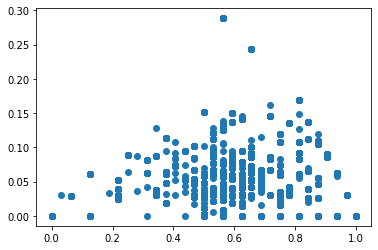

In [37]:
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_train)
accuracy_score(y_train, y_pred)

plt.scatter(X_without_rock[:, 0], X_without_rock[:, 2])

In [38]:

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
xy = pca.fit_transform(X_train)

#plt.scatter(xy[y_without_rock == 'jazz', 0], xy[y_without_rock == 'jazz', 1])
#plt.scatter(xy[y_without_rock == 'rock', 0], xy[y_without_rock == 'rock', 1])



((1000, 36), (12599, 36))

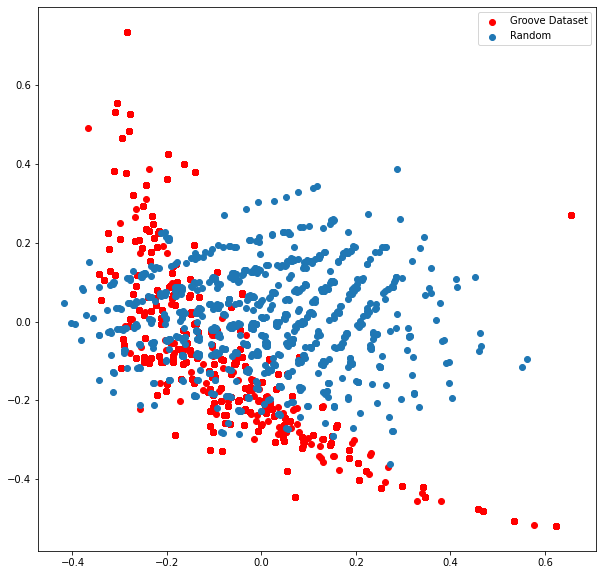

In [41]:
import random
x_random = []
y_random = []
z_random = []
w_random = []
for i in range(1000):
  p = [0]*32
  for j in range(32):
    p[j] = random.randint(0, 1);
  
  if(len(p)>1):
    x_random.append(balance(p))
    y_random.append(entropy(IOI(p)))
    z_random.append(evenness(p))
    w_random.append(IOI(p))
  

x = np.asarray(x_random)
y = np.asarray(y_random)
z = np.asarray(z_random)
w = np.asarray(w_random)

X_random = np.stack([x_random, y_random, z_random], axis=1)
X_random = np.hstack([X_random, w_random])


from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_random = pca.fit_transform(X_random)


plt.figure(figsize=(10, 10))
plt.scatter(xy[:, 0], xy[:, 1], c='red')
plt.scatter(pca_random[:, 0], pca_random[:, 1])
plt.legend(['Groove Dataset', 'Random'])


X_random.shape, X_train.shape

